In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

from sqlalchemy import create_engine
import urllib

server = r'DESKTOP-1IV1IS2\SQLEXPRESS'
database = 'DataWarehouse'

params = urllib.parse.quote_plus(
    f"DRIVER=ODBC Driver 17 for SQL Server;"
    f"SERVER={server};"
    f"DATABASE={database};"
    "Trusted_Connection=yes;"
)

engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

connection = engine.connect()

df = pd.read_sql("SELECT * FROM gold.report_customers", connection)
df.head()

,customer_key,customer_number,customer_name,age,age_group,customer_segment,last_order_date,recency,total_orders,total_sales,total_quantity,lifespan,avg_order_value,avg_monthly_spend
0,1,AW00011000,Jon Yang,55.0,above 50,VIP,2013-05-03,152,3,8249,8,28,2749,294
1,2,AW00011001,Eugene Huang,50.0,above 50,VIP,2013-12-10,145,3,6384,11,35,2128,182
2,3,AW00011002,Ruben Torres,55.0,above 50,VIP,2013-02-23,155,3,8114,4,25,2704,324
3,4,AW00011003,Christy Zhu,53.0,above 50,VIP,2013-05-10,152,3,8139,9,29,2713,280
4,5,AW00011004,Elizabeth Johnson,47.0,40-49,VIP,2013-05-01,152,3,8196,6,28,2732,292


In [35]:
df.shape

(18482, 14)

In [36]:
df.describe()

,customer_key,age,recency,total_orders,total_sales,total_quantity,lifespan,avg_order_value,avg_monthly_spend
count,18482.000000,18465.000000,18482.000000,18482.000000,18482.000000,18482.000000,18482.000000,18482.000000,18482.000000
mean,9242.344281,57.177471,149.793962,1.496429,1588.099665,3.268261,5.169841,911.652364,452.775133
std,5335.992085,11.535341,4.796985,1.101186,2123.778423,2.631571,8.513890,1040.614162,738.903025
min,1.000000,40.000000,144.000000,1.000000,2.000000,1.000000,0.000000,2.000000,1.000000
25%,4621.250000,48.000000,146.000000,1.000000,50.000000,2.000000,0.000000,40.000000,39.000000
50%,9242.500000,55.000000,149.000000,1.000000,272.000000,3.000000,0.000000,157.000000,122.000000
75%,13862.750000,65.000000,152.000000,2.000000,2511.000000,4.000000,9.000000,1770.000000,471.000000
max,18484.000000,110.000000,181.000000,28.000000,13294.000000,68.000000,36.000000,3578.000000,4219.000000


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18482 entries, 0 to 18481
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_key       18482 non-null  int64  
 1   customer_number    18482 non-null  object 
 2   customer_name      18482 non-null  object 
 3   age                18465 non-null  float64
 4   age_group          18482 non-null  object 
 5   customer_segment   18482 non-null  object 
 6   last_order_date    18482 non-null  object 
 7   recency            18482 non-null  int64  
 8   total_orders       18482 non-null  int64  
 9   total_sales        18482 non-null  int64  
 10  total_quantity     18482 non-null  int64  
 11  lifespan           18482 non-null  int64  
 12  avg_order_value    18482 non-null  int64  
 13  avg_monthly_spend  18482 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 2.0+ MB


In [38]:
df['last_order_date'] = pd.to_datetime(df['last_order_date'], errors= 'coerce')
df['age'] = df['age'].astype('Int64')
df.dtypes

customer_key                  int64
customer_number              object
customer_name                object
age                           Int64
age_group                    object
customer_segment             object
last_order_date      datetime64[ns]
recency                       int64
total_orders                  int64
total_sales                   int64
total_quantity                int64
lifespan                      int64
avg_order_value               int64
avg_monthly_spend             int64
dtype: object

# Recency Frequency Monetary (RFM) Analysis

In [39]:
rfm = df[['customer_key', 'recency', 'total_orders', 'total_sales']].copy()

rfm.columns = ['customer_key', 'Recency', 'Frequency', 'Monetary']

In [40]:
rfm.head()

,customer_key,Recency,Frequency,Monetary
0,1,152,3,8249
1,2,145,3,6384
2,3,155,3,8114
3,4,152,3,8139
4,5,152,3,8196


In [41]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

# Business-meaningful frequency bins
F_edges = [0, 1, 2, 5, 10, rfm['Frequency'].max()]
rfm['F_score'] = pd.cut(rfm['Frequency'], bins=F_edges, labels=[1, 2, 3, 4, 5], include_lowest=True)

rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

In [42]:
rfm

,customer_key,Recency,Frequency,Monetary,R_score,F_score,M_score
0,1,152,3,8249,2,3,5
1,2,145,3,6384,5,3,5
2,3,155,3,8114,1,3,5
3,4,152,3,8139,2,3,5
4,5,152,3,8196,2,3,5
...,...,...,...,...,...,...,...
18477,18480,160,1,2049,1,1,4
18478,18481,150,1,2442,3,1,4
18479,18482,173,1,3375,1,1,5
18480,18483,160,1,2049,1,1,4


In [43]:
# See the actual value ranges behind each R score
(rfm.groupby('R_score', observed=False)['Recency'].agg(['min','max','count']),
rfm.groupby('F_score', observed=False)['Frequency'].agg(['min','max','count']),
rfm.groupby('M_score', observed=False)['Monetary'].agg(['min','max','count']))

(         min  max  count
 R_score                 
 5        144  146   4815
 4        147  148   3467
 3        149  150   3058
 2        151  153   4035
 1        154  181   3107,
          min  max  count
 F_score                 
 1          1    1  11617
 2          2    2   5454
 3          3    5   1367
 4          6    7      9
 5         16   28     35,
           min    max  count
 M_score                    
 1           2     40   4169
 2          41     92   3232
 3          93   1155   3709
 4        1158   3271   3676
 5        3273  13294   3696)

In [44]:
rfm = rfm[['customer_key', 'Recency', 'Frequency', 'Monetary',
           'R_score', 'F_score', 'M_score']].copy()

rfm['RFM_Score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)


In [45]:
rfm

,customer_key,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
0,1,152,3,8249,2,3,5,235
1,2,145,3,6384,5,3,5,535
2,3,155,3,8114,1,3,5,135
3,4,152,3,8139,2,3,5,235
4,5,152,3,8196,2,3,5,235
...,...,...,...,...,...,...,...,...
18477,18480,160,1,2049,1,1,4,114
18478,18481,150,1,2442,3,1,4,314
18479,18482,173,1,3375,1,1,5,115
18480,18483,160,1,2049,1,1,4,114


In [46]:
# segment based on rfm scores
def rfm_segment(row):
    
    # Champions:
    # - Very recent buyers (high R)
    # - Buy frequently (high F)
    # - Spend a lot (high M)
    # These customers drive the most value and should be retained and rewarded.
    if row['R_score'] >= 4 and row['F_score'] >= 4 and row['M_score'] >= 4:
        return 'Champions'

    # Loyal Customers:
    # - Recent buyers
    # - Buy relatively often
    # - May not always be the highest spenders
    # These customers are consistent and should be nurtured to become Champions.
    elif row['R_score'] >= 4 and row['F_score'] >= 3:
        return 'Loyal Customers'

    # At Risk (High Value):
    # - Have not purchased recently (low R)
    # - Historically high spenders (high M)
    # These customers are valuable but showing churn signals
    # and should be targeted with re-engagement campaigns.
    elif row['R_score'] <= 2 and row['M_score'] >= 4:
        return 'At Risk (High Value)'

    
    # Churn Risk:
    # - Have not purchased recently
    # - Low purchase frequency
    # These customers show strong churn behavior and may require incentives
    # or could be deprioritized depending on strategy.
    elif row['R_score'] <= 2 and row['F_score'] <= 2:
        return 'Churn Risk'

    # Needs Attention:
    # - All other customers who do not strongly fit the above categories
    # These customers have moderate behavior and require monitoring.
    else:
        return 'Needs Attention'

rfm['engagement_level'] = rfm.apply(rfm_segment, axis=1)


In [47]:
rfm.sample(10)

,customer_key,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,engagement_level
17724,17727,146,1,778,5,1,3,513,Needs Attention
9936,9938,148,1,120,4,1,3,413,Needs Attention
10605,10607,146,1,1155,5,1,3,513,Needs Attention
3830,3831,152,3,8346,2,3,5,235,At Risk (High Value)
11163,11165,151,1,563,2,1,3,213,Churn Risk
7488,7490,154,2,6080,1,2,5,125,At Risk (High Value)
16278,16281,148,2,4447,4,2,5,425,Needs Attention
11718,11720,150,1,567,3,1,3,313,Needs Attention
11797,11799,152,1,25,2,1,1,211,Churn Risk
5261,5262,146,3,7170,5,3,5,535,Loyal Customers


In [48]:
rfm['engagement_level'].value_counts()


engagement_level
Needs Attention         10394
Churn Risk               4163
At Risk (High Value)     2952
Loyal Customers           955
Champions                  18
Name: count, dtype: int64

In [49]:
df = df.merge(rfm[['customer_key', 'R_score', 'F_score', 'M_score', 'engagement_level']],
              on='customer_key',
              how='left')
df

,customer_key,customer_number,customer_name,age,age_group,customer_segment,last_order_date,recency,total_orders,total_sales,total_quantity,lifespan,avg_order_value,avg_monthly_spend,R_score,F_score,M_score,engagement_level
0,1,AW00011000,Jon Yang,55,above 50,VIP,2013-05-03,152,3,8249,8,28,2749,294,2,3,5,At Risk (High Value)
1,2,AW00011001,Eugene Huang,50,above 50,VIP,2013-12-10,145,3,6384,11,35,2128,182,5,3,5,Loyal Customers
2,3,AW00011002,Ruben Torres,55,above 50,VIP,2013-02-23,155,3,8114,4,25,2704,324,1,3,5,At Risk (High Value)
3,4,AW00011003,Christy Zhu,53,above 50,VIP,2013-05-10,152,3,8139,9,29,2713,280,2,3,5,At Risk (High Value)
4,5,AW00011004,Elizabeth Johnson,47,40-49,VIP,2013-05-01,152,3,8196,6,28,2732,292,2,3,5,At Risk (High Value)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18477,18480,AW00029479,Tommy Tang,57,above 50,New,2012-09-04,160,1,2049,1,0,2049,2049,1,1,4,At Risk (High Value)
18478,18481,AW00029480,Nina Raji,49,40-49,New,2013-07-17,150,1,2442,5,0,2442,2442,3,1,4,Needs Attention
18479,18482,AW00029481,Ivan Suri,61,above 50,New,2011-08-13,173,1,3375,1,0,3375,3375,1,1,5,At Risk (High Value)
18480,18483,AW00029482,Clayton Zhang,62,above 50,New,2012-09-18,160,1,2049,1,0,2049,2049,1,1,4,At Risk (High Value)


In [50]:
df.groupby('engagement_level')['recency'].agg(['mean','median','count']).sort_values('mean')

,mean,median,count
engagement_level,,,
Champions,145.000000,145.0,18
Loyal Customers,145.974869,146.0,955
Needs Attention,147.166538,147.0,10394
Churn Risk,153.121787,153.0,4163
At Risk (High Value),155.616870,153.0,2952


# This segment show a clean monotonic trend:
- Champions → Loyal → Needs Attention → Churn Risk → At Risk (High Value)
-  (low recency) ---------------------------------------------- (high recency)


- Engagement level exhibit a clear increase in recency from Champions to At-Risk customers, validating the effectiveness of the RFM-based churn classification.

In [51]:
df.groupby(['age_group', 'customer_segment']).agg({'engagement_level': 'value_counts'})

engagement_level
age_group customer_segment engagement_level                      
40-49     New              Needs Attention                   2424
                           Churn Risk                        1291
                           At Risk (High Value)               576
                           Loyal Customers                    131
                           Champions                            1
          Regular          Needs Attention                    508
                           At Risk (High Value)               224
                           Loyal Customers                     20
          VIP              Needs Attention                    165
                           Loyal Customers                    149
                           At Risk (High Value)               147
above 50  New              Needs Attention                   5807
                           Churn Risk                        2872
                           At Risk (High Value)              1271
                           Loyal Customers                    249
                           Champions                            7
          Regular          Needs Attention                   1069
                           At Risk (High Value)               324
                           Loyal Customers                     52
                           Champions                            3
          VIP              Needs Attention                    421
                           At Risk (High Value)               410
                           Loyal Customers                    354
                           Champions                            7

# Customer Lifecycle & Value Insights:
- Younger customers (30-39) need attention early on.
- Older customers (40+) are more loyal when VIP.
- High-value customers are at risk across the board - need retention focus.
- Lots of new customers need engagement boost.

In [52]:
df.head()

,customer_key,customer_number,customer_name,age,age_group,customer_segment,last_order_date,recency,total_orders,total_sales,total_quantity,lifespan,avg_order_value,avg_monthly_spend,R_score,F_score,M_score,engagement_level
0,1,AW00011000,Jon Yang,55,above 50,VIP,2013-05-03,152,3,8249,8,28,2749,294,2,3,5,At Risk (High Value)
1,2,AW00011001,Eugene Huang,50,above 50,VIP,2013-12-10,145,3,6384,11,35,2128,182,5,3,5,Loyal Customers
2,3,AW00011002,Ruben Torres,55,above 50,VIP,2013-02-23,155,3,8114,4,25,2704,324,1,3,5,At Risk (High Value)
3,4,AW00011003,Christy Zhu,53,above 50,VIP,2013-05-10,152,3,8139,9,29,2713,280,2,3,5,At Risk (High Value)
4,5,AW00011004,Elizabeth Johnson,47,40-49,VIP,2013-05-01,152,3,8196,6,28,2732,292,2,3,5,At Risk (High Value)


In [53]:
df[df['engagement_level'].isin(['At Risk (High Value)', 'Churn Risk'])]['total_sales'].sum()

np.int64(11146985)

In [54]:
df[df['engagement_level'].isin(['Champions', 'Loyal Customers'])]['total_sales'].sum()

np.int64(3961255)

# Sales Imbalance: High-Risk vs Loyal Segments
- High-risk segments (At Risk + Churn Risk) generate almost 3x more sales than loyal segments (Champions + Loyal Customers). 
- Focus on retaining these high-value at-risk customers to sustain revenue.

# Customer Lifetime Value (CLV) Analysis

In [55]:
df['customer_lifetime_value'] = df['lifespan'] * df['avg_monthly_spend']

In [56]:
df.head(2)

,customer_key,customer_number,customer_name,age,age_group,customer_segment,last_order_date,recency,total_orders,total_sales,total_quantity,lifespan,avg_order_value,avg_monthly_spend,R_score,F_score,M_score,engagement_level,customer_lifetime_value
0,1,AW00011000,Jon Yang,55,above 50,VIP,2013-05-03,152,3,8249,8,28,2749,294,2,3,5,At Risk (High Value),8232
1,2,AW00011001,Eugene Huang,50,above 50,VIP,2013-12-10,145,3,6384,11,35,2128,182,5,3,5,Loyal Customers,6370


In [57]:
df[['customer_key', 'avg_monthly_spend', 'lifespan', 'customer_lifetime_value']].head()

,customer_key,avg_monthly_spend,lifespan,customer_lifetime_value
0,1,294,28,8232
1,2,182,35,6370
2,3,324,25,8100
3,4,280,29,8120
4,5,292,28,8176


In [58]:
df.groupby('engagement_level')['customer_lifetime_value'].mean().sort_values(ascending=False)

engagement_level
Champions               6271.944444
Loyal Customers         4022.430366
At Risk (High Value)    2545.242886
Needs Attention         1063.623629
Churn Risk                 5.210185
Name: customer_lifetime_value, dtype: float64

# Avgrage Lifetime Value by Engagement Level
- Customer lifetime value declines sharply from Champions to Churn Risk segments
- confirming that engagement level is a strong indicator of long-term customer value and validating the RFM-based segmentation approach.

In [59]:
df[(df['engagement_level'] == 'At Risk (High Value)') & (df['customer_lifetime_value'] > df['customer_lifetime_value'].median())]

,customer_key,customer_number,customer_name,age,age_group,customer_segment,last_order_date,recency,total_orders,total_sales,total_quantity,lifespan,avg_order_value,avg_monthly_spend,R_score,F_score,M_score,engagement_level,customer_lifetime_value
0,1,AW00011000,Jon Yang,55,above 50,VIP,2013-05-03,152,3,8249,8,28,2749,294,2,3,5,At Risk (High Value),8232
2,3,AW00011002,Ruben Torres,55,above 50,VIP,2013-02-23,155,3,8114,4,25,2704,324,1,3,5,At Risk (High Value),8100
3,4,AW00011003,Christy Zhu,53,above 50,VIP,2013-05-10,152,3,8139,9,29,2713,280,2,3,5,At Risk (High Value),8120
4,5,AW00011004,Elizabeth Johnson,47,40-49,VIP,2013-05-01,152,3,8196,6,28,2732,292,2,3,5,At Risk (High Value),8176
5,6,AW00011005,Julio Ruiz,50,above 50,VIP,2013-05-02,152,3,8121,6,29,2707,280,2,3,5,At Risk (High Value),8120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18396,18399,AW00029398,Bruce Suri,55,above 50,Regular,2013-02-08,155,2,3964,3,22,1982,180,1,2,5,At Risk (High Value),3960
18397,18400,AW00029399,Janet Gomez,50,above 50,Regular,2013-03-10,154,2,3936,3,23,1968,171,1,2,5,At Risk (High Value),3933
18398,18401,AW00029400,Marvin Browning,50,above 50,Regular,2013-03-16,154,2,3993,5,22,1996,181,1,2,5,At Risk (High Value),3982
18401,18404,AW00029403,Erik Romero,56,above 50,Regular,2013-04-03,153,2,3992,6,23,1996,173,2,2,5,At Risk (High Value),3979


# Visualization Insights
- Average CLV by Engagement Level
- Customer Distribution by Segment
- Revenue at Risk

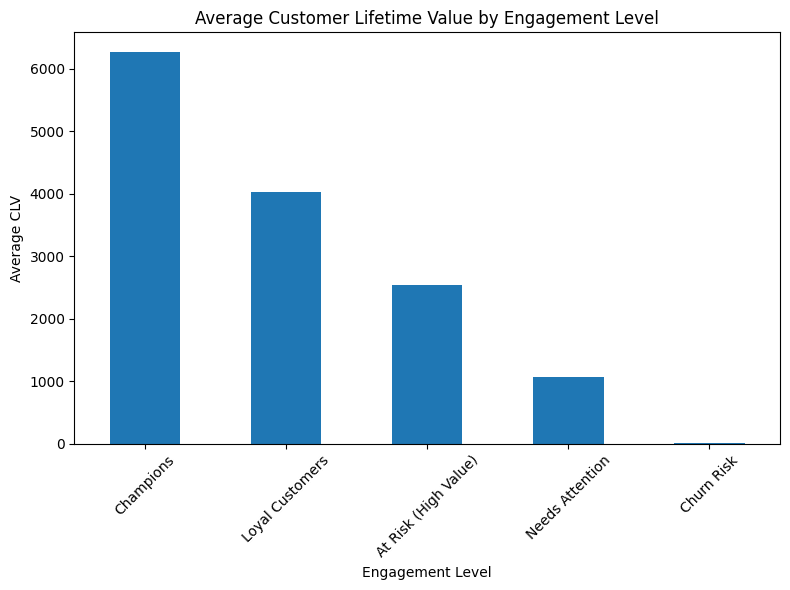

In [60]:
# Average CLV by Engagement Level


clv_by_segment = (
    df.groupby('engagement_level')['customer_lifetime_value']
      .mean()
      .sort_values(ascending=False)
)

plt.figure()
clv_by_segment.plot(kind='bar')
plt.title('Average Customer Lifetime Value by Engagement Level')
plt.xlabel('Engagement Level')
plt.ylabel('Average CLV')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

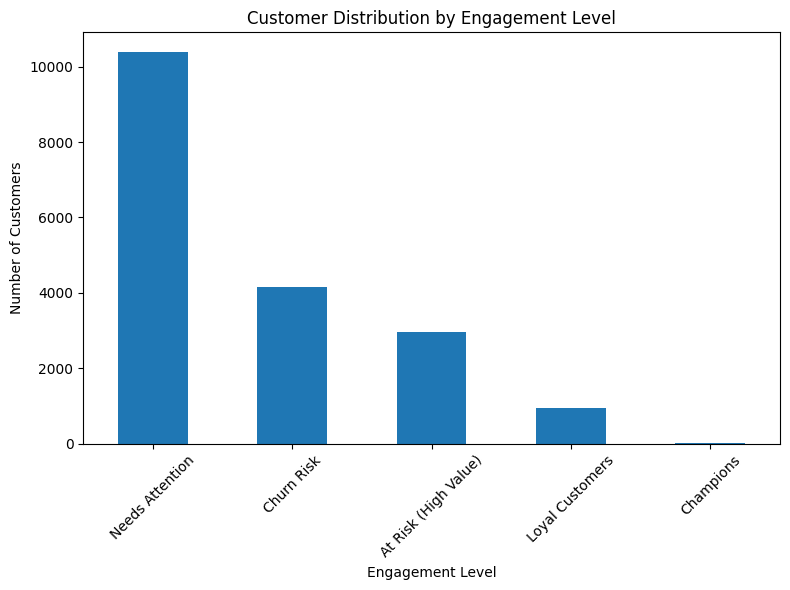

In [61]:
# Customer Distribution by Engagement Level

segment_counts = df['engagement_level'].value_counts()

plt.figure()
segment_counts.plot(kind='bar')
plt.title('Customer Distribution by Engagement Level')
plt.xlabel('Engagement Level')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

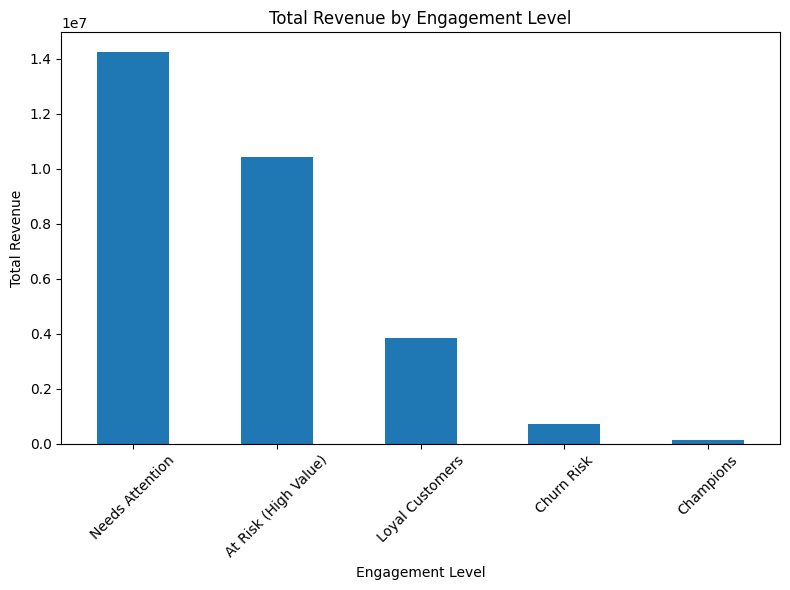

In [62]:
# Revenue at Risk

revenue_by_segment = (
    df.groupby('engagement_level')['total_sales']
      .sum()
      .sort_values(ascending=False)
)

plt.figure()
revenue_by_segment.plot(kind='bar')
plt.title('Total Revenue by Engagement Level')
plt.xlabel('Engagement Level')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [63]:
final_table = pd.DataFrame({
    'Engagement Level': [
        'Champions',
        'Loyal Customers',
        'At Risk (High Value)',
        'Needs Attention',
        'Churn Risk'
    ],
    'Avg CLV': [
        6271.94,
        4022.43,
        2545.24,
        1063.62,
        5.21
    ],
    'Priority': [
        'Critical',
        'High',
        'Critical',
        'Medium',
        'Low'
    ],
    'Strategy': [
        'Retain & reward',
        'Upsell & cross-sell',
        'Win-back campaigns',
        'Engagement nudges',
        'Deprioritize'
    ]
})

final_table


,Engagement Level,Avg CLV,Priority,Strategy
0,Champions,6271.94,Critical,Retain & reward
1,Loyal Customers,4022.43,High,Upsell & cross-sell
2,At Risk (High Value),2545.24,Critical,Win-back campaigns
3,Needs Attention,1063.62,Medium,Engagement nudges
4,Churn Risk,5.21,Low,Deprioritize


## Customer Value & Engagement Action Matrix

| Engagement Level     | Avg CLV | Priority     | Strategy                                    |
| -------------------- | ------: | ------------ | ------------------------------------------- |
| Champions            |  ~6,272 | **Critical** | Retain & reward (loyalty perks, exclusives) |
| Loyal Customers      |  ~4,022 | **High**     | Upsell & cross-sell to move to Champions    |
| At Risk (High Value) |  ~2,545 | **Critical** | Win-back campaigns, personalized offers     |
| Needs Attention      |  ~1,064 | **Medium**   | Engagement nudges, reminders, light promos  |
| Churn Risk           |      ~5 | **Low**      | Deprioritize or low-cost reactivation       |
